# Condensation Tutorial: Radius Bin

> **Note:** This notebook is a work in progress and demonstrates basic setup
> for condensation processes. For a complete working example, see
> `Staggered_Condensation_Example.ipynb` which uses particle-resolved
> representations that work seamlessly with the condensation framework.

Condensation is the first process where this framework we have been building
up is applied. Here we need to account for the gas phase and the particle
phase, then ensure that the partial pressures of species at the surface of
the particle are equal to the partial pressure in the gas.

**Core Concepts:**

- **Runnable**: An abstract base class defining the interface for aerosol
  transformation processes. An aerosol object is passed to the process, and
  the process is expected to modify the aerosol object in place, returning
  the modified object.
- **MassCondensation**: A concrete class implementing the RunnableProcess
  interface for the condensation process. It adds mass to the aerosol object
  based on the partial pressures of the gas phase and the particle phase,
  then removes the mass from the gas phase.


In [1]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np

# particula imports
import particula as par

## Setup Aerosol

First we will repeat the aerosol object that we have been using in the previous notebooks. This object will be passed to the `Runnable` processes `MassCondensation`, and modified in place.

In [2]:
# Glycerol gas
molar_mass_glycerol = 92.09382e-3  # kg/mol
parameters_clausius = {
    "latent_heat": 71.5 * molar_mass_glycerol,
    "latent_heat_units": "kJ/mol",
    "temperature_initial": 125.5,
    "temperature_initial_units": "degC",
    "pressure_initial": 1,
    "pressure_initial_units": "mmHg",
}
vapor_pressure_strategy = par.gas.VaporPressureFactory().get_strategy(
    "clausius_clapeyron", parameters_clausius
)

sat_concentration = vapor_pressure_strategy.saturation_concentration(
    molar_mass_glycerol, 298.15
)
print(f"Saturation concentration: {sat_concentration:.2e} kg/m^3")

sat_factor = 0.01  # 50% of saturation concentration
glycerol_gas = (
    par.gas.GasSpeciesBuilder()
    .set_molar_mass(molar_mass_glycerol, "kg/mol")
    .set_vapor_pressure_strategy(vapor_pressure_strategy)
    .set_concentration(sat_concentration * sat_factor, "kg/m^3")
    .set_name("Glycerol")
    .set_partitioning(True)
    .build()
)

atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(glycerol_gas)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

# Glycerol particle distribution
bins = np.logspace(-8, -5, 500)
lognormal_rep = (
    par.particles.PresetParticleRadiusBuilder()
    .set_mode(np.array([100]), "nm")
    .set_geometric_standard_deviation(np.array([1.3]))
    .set_number_concentration(np.array([1e4]), "1/cm^3")
    .set_density(1.26, "g/cm^3")
    .set_distribution_type("pmf")
    .set_radius_bins(bins, "m")
    .build()
)

aerosol = par.Aerosol(atmosphere=atmosphere, particles=lognormal_rep)

print(aerosol)

Saturation concentration: 2.54e-03 kg/m^3
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=Glycerol, gas_only_species=None
Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 7.194e-08 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


## Condensation Process (Isothermal)

In code this process is implemented as a `Runnable` process. This means that the process is expected to modify the aerosol object in place, returning the modified aerosol object. This is defined in `Particle_processes.py` as the `MassCondensation` class.

The `MassCondensation` class takes a `CondensationStrategy` object as an input. This object defines and evaluates the $dm_{i}/dt$ equation for the condensation process. More strategies can be added into the `condensation.py` file.

For now, let's just run it for a few time steps and see what happens.

Note: We have a moving bin particle representation, so we would expect all the bins to move.

In [3]:
# define the condensation process
condensation_isothermal = par.dynamics.CondensationIsothermal(
    molar_mass=molar_mass_glycerol,
    diffusion_coefficient=2e-5,
    accommodation_coefficient=0.1,  # makes things go slower/faster
)
condensation_process = par.dynamics.MassCondensation(
    condensation_strategy=condensation_isothermal
)
print(f"Strategy: {condensation_isothermal}")
print(f"Runnable: {condensation_process}")

Strategy: <particula.dynamics.condensation.condensation_strategies.CondensationIsothermal object at 0x7f0c8b0cfe00>
Runnable: <particula.dynamics.particle_process.MassCondensation object at 0x7f0c8a49e480>


In [4]:
# Get the initial state for plotting
initial_radii = aerosol.particles.get_radius().copy()
initial_concentration = aerosol.particles.concentration.copy()

# Calculate the condensation rate (mass change per particle per second)
rate = condensation_process.rate(aerosol)
print(f"Condensation rate shape: {rate.shape}")
print(f"Mean rate: {np.mean(rate):.2e} kg/s per particle")

Condensation rate shape: (500,)
Mean rate: 2.45e-09 kg/s per particle


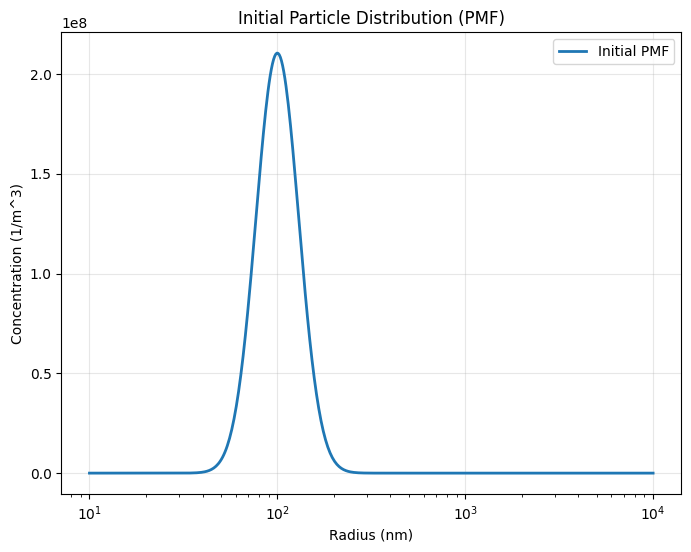

In [5]:
# Plot the initial particle distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx(
    initial_radii * 1e9,
    initial_concentration,
    label="Initial PMF",
    linewidth=2,
)
ax.set_xlabel("Radius (nm)")
ax.set_ylabel("Concentration (1/m^3)")
ax.legend()
ax.set_title("Initial Particle Distribution (PMF)")
ax.grid(alpha=0.3)
plt.show()

> **Note:** Full time evolution with bin-based representations requires
> careful handling of the distribution array dimensions. For complete
> working examples of condensation dynamics, see
> `Staggered_Condensation_Example.ipynb` which uses particle-resolved
> representations that are designed for multi-step simulations.

## Summary

This notebook demonstrated the basic setup for condensation with:

- **Vapor Pressure Strategy**: Clausius-Clapeyron equation for glycerol
- **Gas Species**: Built with `GasSpeciesBuilder` with partitioning enabled
- **Particle Distribution**: PMF (bin-based) representation
- **Condensation Strategy**: `CondensationIsothermal` for simple mass transfer
- **Runnable Process**: `MassCondensation` wraps the strategy

For complete time evolution examples with particle-resolved representations,
see `Staggered_Condensation_Example.ipynb`.